In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [3]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
df_raw = pd.read_json(path_or_buf='/kaggle/input/vc-it-cup-ranking/ranking_train.jsonl', lines=True)

In [5]:
posts = df_raw['text']
comments = df_raw.explode('comments')['comments'].to_frame()

In [6]:
def get_basic_statistics(df):
    res = pd.DataFrame()
    res["char_count"] = df.parallel_map(lambda x: len(x))
    res["word_count"] = df.parallel_map(lambda x: len(x.split()))
    res["sent_count"] = df.parallel_map(lambda x: len(sent_tokenize(x)))
    res['digits_count'] = df.parallel_map(lambda x: sum([i.isdigit() for i in word_tokenize(x)]))
    res["avg_word_len"] = df.parallel_map(lambda x: np.mean([len(w) for w in str(x).split()]))
    res["avg_sent_len"] = df.parallel_map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
    return res

In [7]:
posts_stats = get_basic_statistics(posts)

In [8]:
posts_stats.describe()

,char_count,word_count,sent_count,digits_count,avg_word_len,avg_sent_len
count,88107.000000,88107.000000,88107.000000,88107.000000,88107.000000,88107.000000
mean,45.676916,7.750474,1.046863,0.112204,5.211993,7.524956
std,17.335862,3.107059,0.231346,0.356550,1.331764,3.063182
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,33.000000,5.000000,1.000000,0.000000,4.363636,5.000000
50%,45.000000,8.000000,1.000000,0.000000,5.000000,7.000000
75%,58.000000,10.000000,1.000000,0.000000,5.833333,10.000000
max,152.000000,26.000000,7.000000,10.000000,78.000000,21.000000


In [9]:
posts_stats[posts_stats['digits_count'] > 0].shape

(8880, 6)

In [10]:
comments['text'] = comments['comments'].apply(lambda x: x['text'])
comments['target'] = comments['comments'].apply(lambda x: x['score'])
comments = comments.drop('comments', axis=1)

In [11]:
comments.head()

,text,target
0,Going back to school is not identical with giv...,0
0,There will invariably be those who don't see t...,1
0,For me school is a way to be connected to what...,2
0,I guess it really depends on how hungry you ar...,3
0,I know pollground decided to go back to school...,4


In [12]:
comments_stats = get_basic_statistics(comments['text'])

In [13]:
comments_stats['target'] = comments['target']
comments_stats['has digets'] = comments_stats['digits_count'] > 0

In [14]:
comments_stats.pivot_table(index='target', aggfunc={"word_count": np.mean, "sent_count": np.mean, 'has digets': np.sum, 'char_count': np.mean, 'avg_sent_len': np.mean, 'avg_word_len': np.mean})

,avg_sent_len,avg_word_len,char_count,has digets,sent_count,word_count
target,,,,,,
0,25.826108,5.618508,839.525679,34502,5.946463,138.716549
1,23.597953,5.568109,574.036694,28096,4.323096,95.098278
2,22.107976,5.640524,462.124621,23934,3.640097,76.704916
3,20.682960,5.646709,396.662694,21456,3.278718,65.952217
4,19.355350,5.629545,343.756001,19235,2.969174,57.308761


In [15]:
import re
import string

def clean_text(text):
    text = text.lower()  
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)    
    text = re.sub("([^\x00-\x7F])+", " ", text)
    return text

In [16]:
posts_cleaned = posts.parallel_map(clean_text)
comments_cleaned = comments.copy()
comments_cleaned['text'] = comments['text'].parallel_map(clean_text)

In [17]:
stop = set(stopwords.words("english"))

corpus_posts = [word for i in posts_cleaned.str.split().values.tolist() for word in i if (word not in stop)]
corpus_comments = [word for i in comments_cleaned['text'].str.split().values.tolist() for word in i if (word not in stop)]

In [18]:
from collections import Counter 

posts_counter = Counter(corpus_posts)
comments_counter = Counter(corpus_comments)


In [19]:
posts_counter.most_common(10)

[('hn', 14857),
 ('ask', 11822),
 ('show', 3235),
 ('google', 3222),
 ('startup', 2711),
 ('new', 2711),
 ('web', 1971),
 ('yc', 1932),
 ('app', 1770),
 ('facebook', 1369)]

In [20]:
comments_counter.most_common(10)

[('like', 152413),
 ('would', 124703),
 ('people', 120736),
 ('one', 108606),
 ('get', 98841),
 ('think', 85132),
 ('time', 80356),
 ('really', 78166),
 ('dont', 75331),
 ('use', 72495)]

<AxesSubplot:>

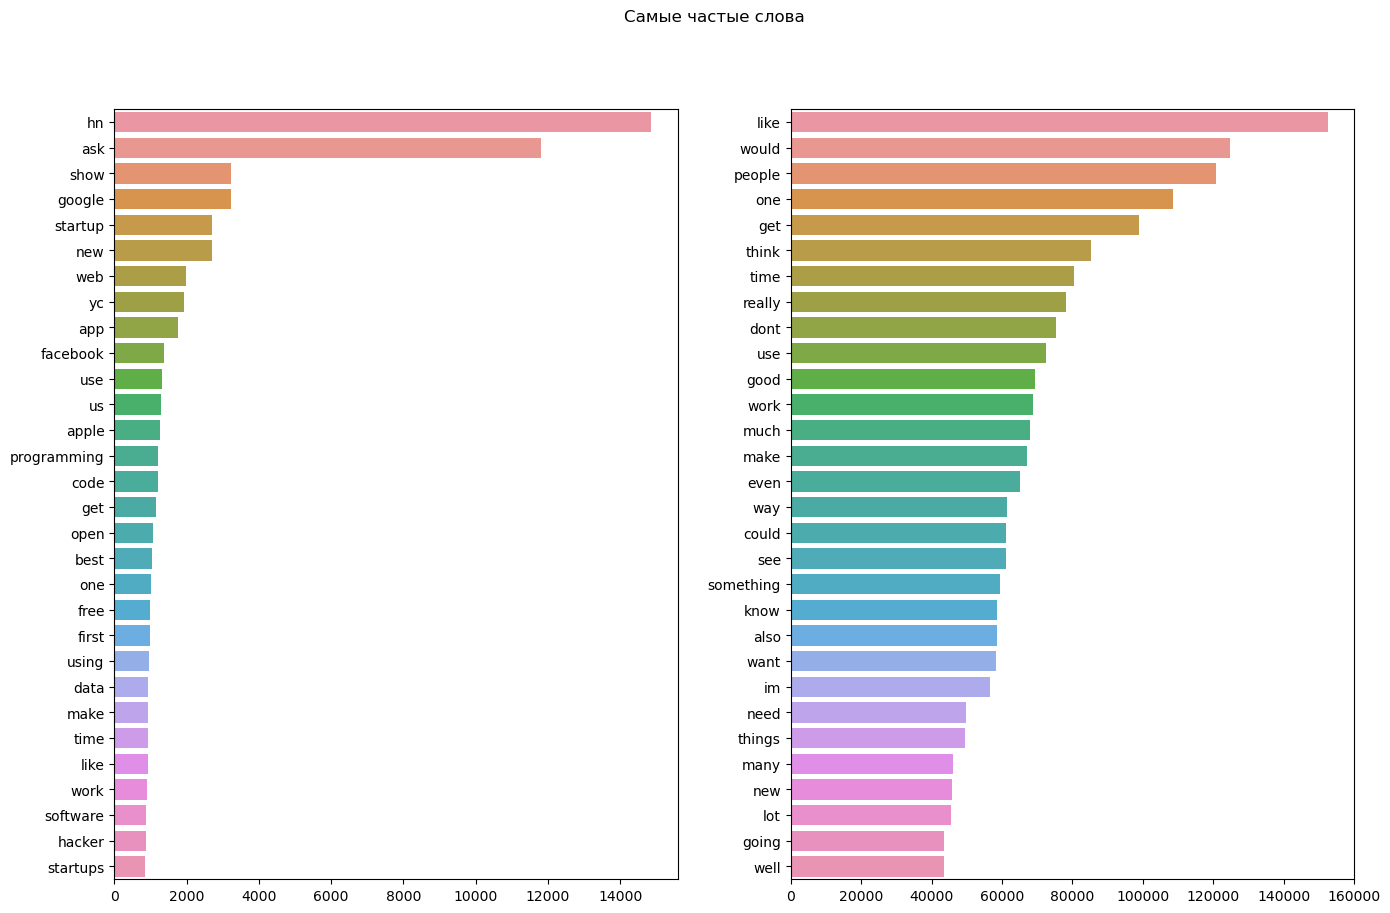

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

plt.suptitle('Самые частые слова')
words, frequency = [], []
for word, count in posts_counter.most_common(30):
    words.append(word)
    frequency.append(count)

sns.barplot(x=frequency, y=words, ax=axes[0])

words, frequency = [], []
for word, count in comments_counter.most_common(30):
    words.append(word)
    frequency.append(count)
    
sns.barplot(x=frequency, y=words, ax=axes[1])

In [22]:
from tqdm import tqdm

counters_by_range = []

for i in tqdm(range(5)):
    current_df = comments_cleaned[comments_cleaned['target'] == i]['text']
    current_corpus = [word for i in current_df.str.split().values.tolist() for word in i if (word not in stop)]
    counters_by_range.append(Counter(current_corpus))


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


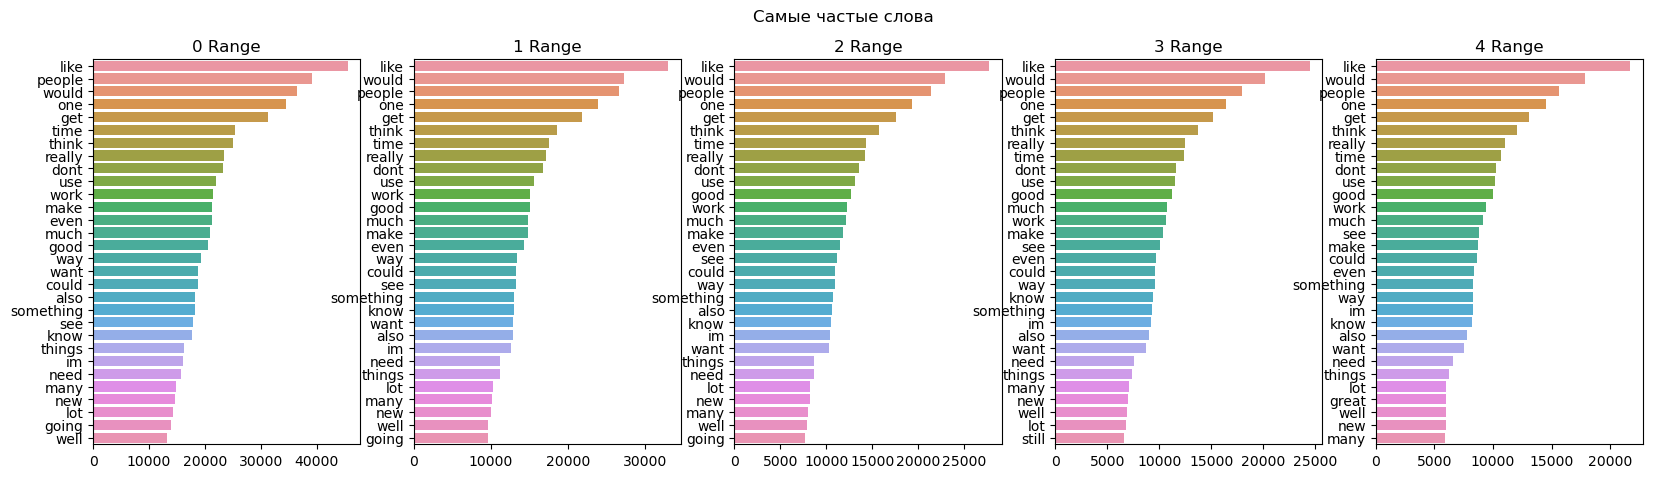

In [91]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(20, 5))
plt.suptitle('Самые частые слова')
for i in range(n):
    words, frequency = [], []
    for word, count in counters_by_range[i].most_common(30):
        words.append(word)
        frequency.append(count)
    sns.barplot(x=frequency, y=words, ax=axes[i])
    axes[i].set_title(f"{i} Range")

Вывод: Надо удалить 20-30 самых встречающихся слов

In [38]:
frequencies = np.array(list(posts_counter.values()))

In [84]:
frequencies[frequencies > 500].shape

(936,)

In [53]:
frequencies.mean()

10.879785215016433

В среднем каждоего слово встречается 10 раз

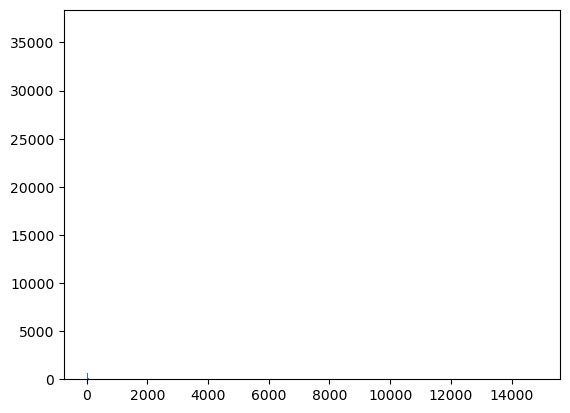

In [59]:
plt.hist(frequencies, bins=2000)
plt.show()

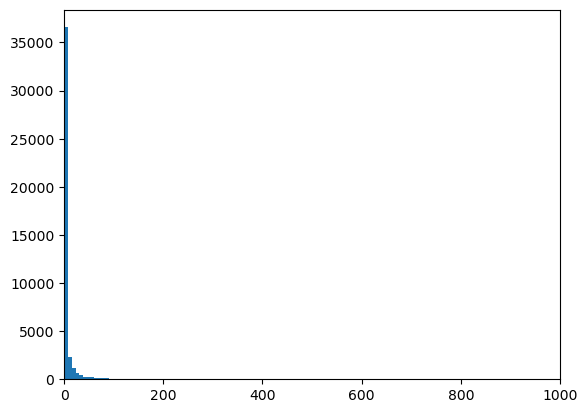

In [60]:
plt.hist(frequencies, bins=2000)
plt.xlim(0, 1000)
plt.show()

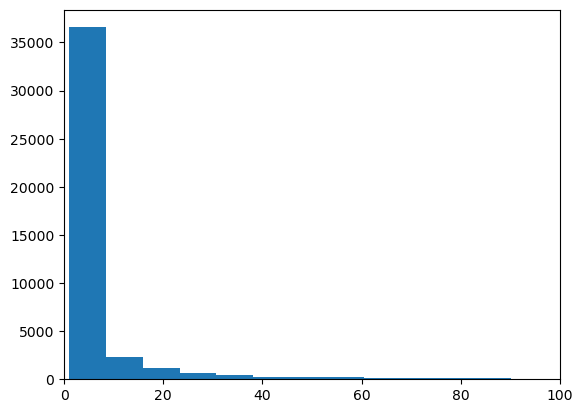

In [57]:
plt.hist(frequencies, bins=2000)
plt.xlim(0, 100)
plt.show()

Большинство слов встречается меньше 9 раз

Распределение частот слов у комментариев 

In [62]:
comments_frequencies = np.array(list(comments_counter.values()))

In [97]:
comments_frequencies.shape

(869044,)

In [96]:
comments_frequencies[comments_frequencies > 250].shape

(7639,)

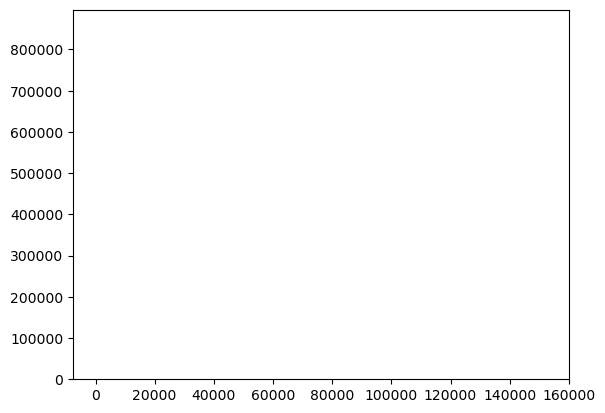

In [63]:
plt.hist(comments_frequencies, bins=2000)
plt.show()

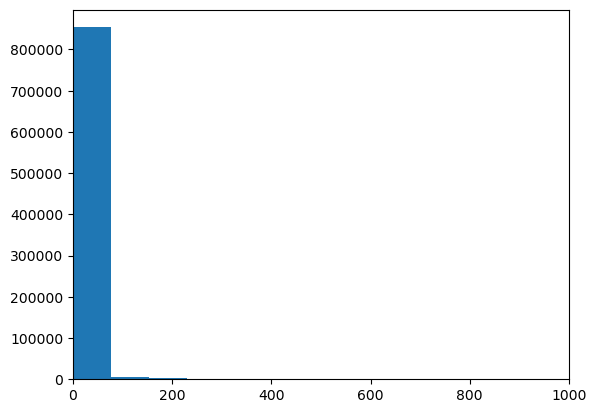

In [67]:
plt.hist(comments_frequencies, bins=2000)
plt.xlim(0, 1000)
plt.show()

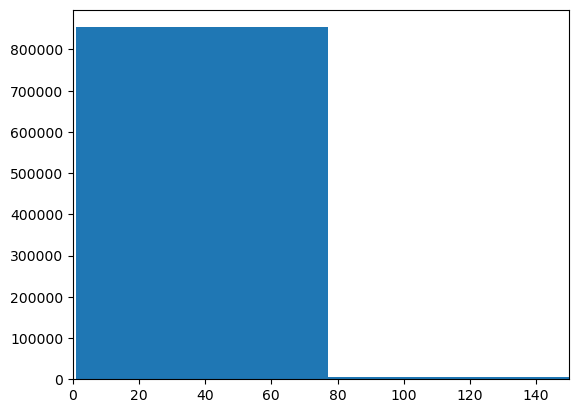

In [68]:
plt.hist(comments_frequencies, bins=2000)
plt.xlim(0, 150)
plt.show()

Теперь для каждого вида ранков

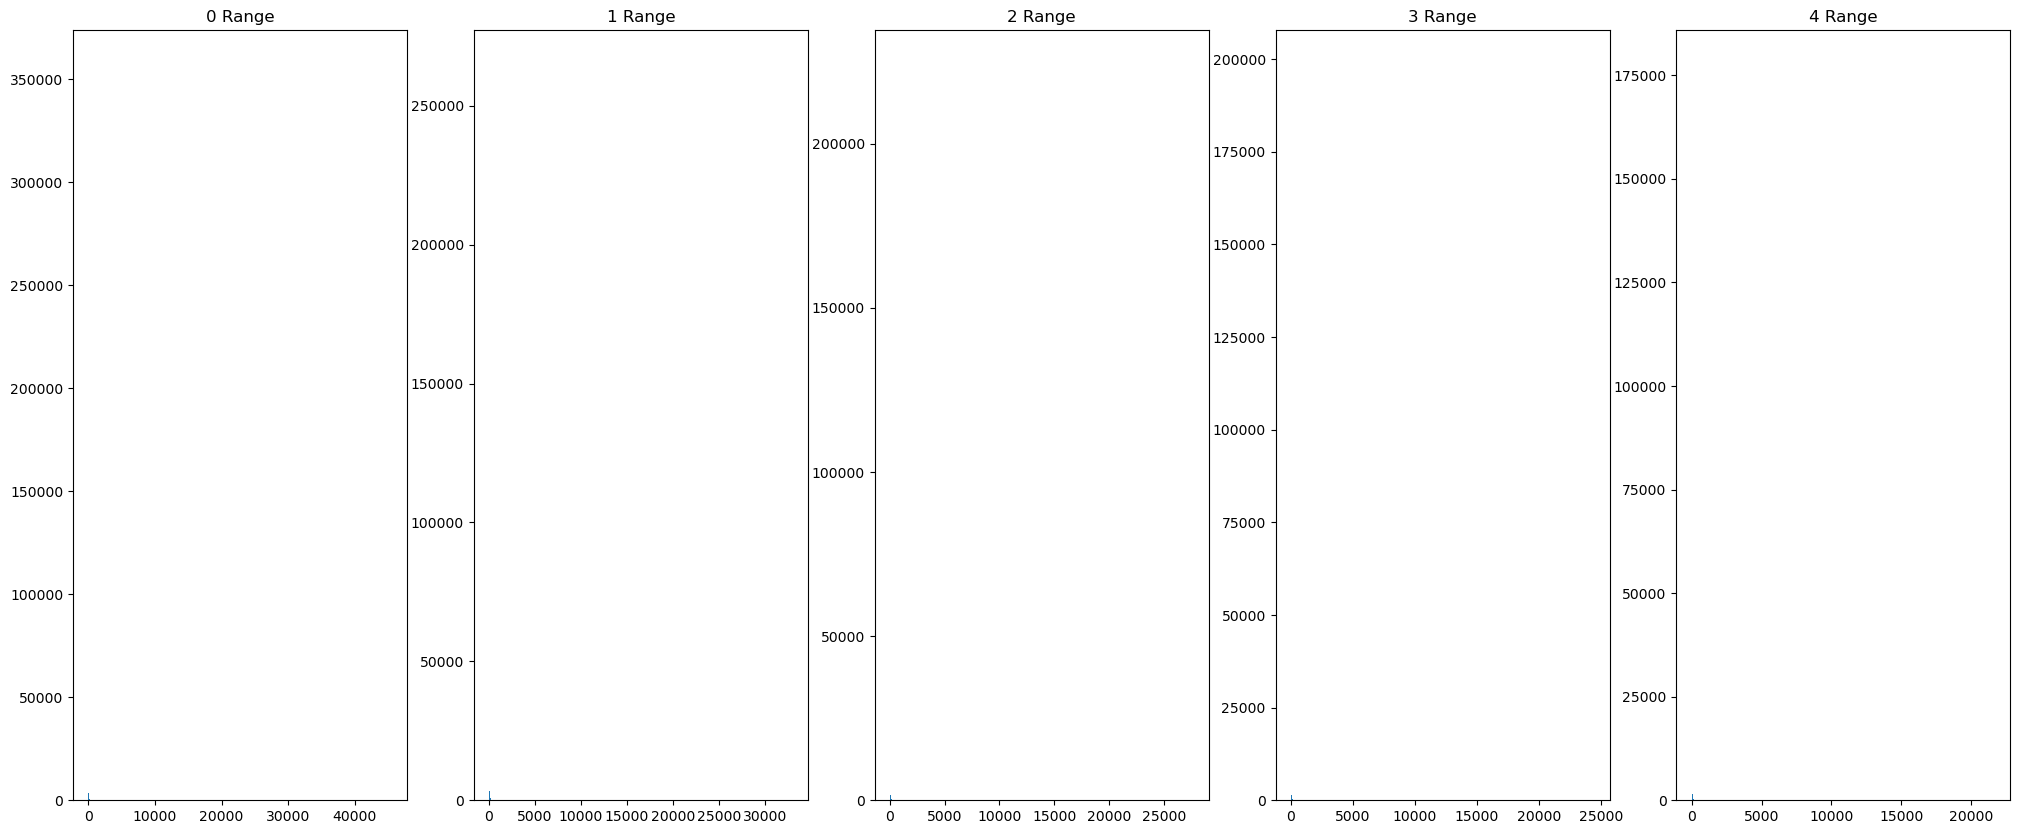

In [72]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(25, 10))
axes = axes.flatten()
for i in range(n):
    frequencies = np.array(list(counters_by_range[i].values()))
    axes[i].hist(frequencies, bins=1000)
    axes[i].set_title(f"{i} Range")

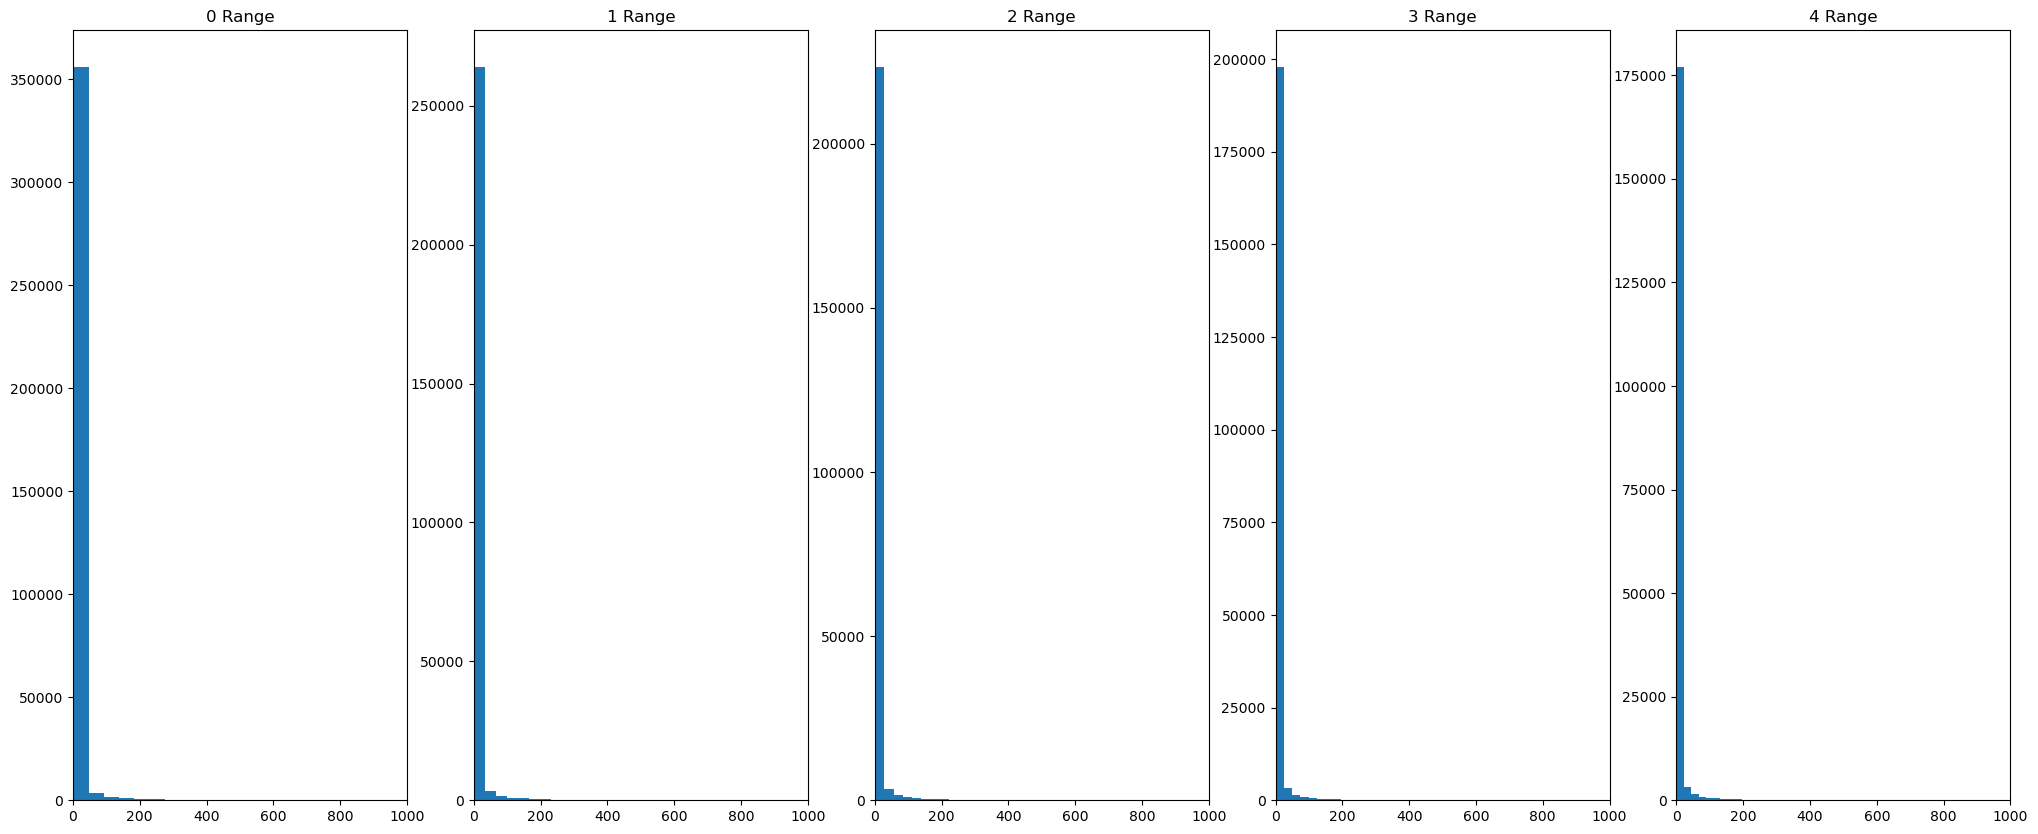

In [75]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(25, 10))
axes = axes.flatten()
for i in range(n):
    frequencies = np.array(list(counters_by_range[i].values()))
    axes[i].hist(frequencies, bins=1000)
    axes[i].set_xlim(0, 1000)
    axes[i].set_title(f"{i} Range")

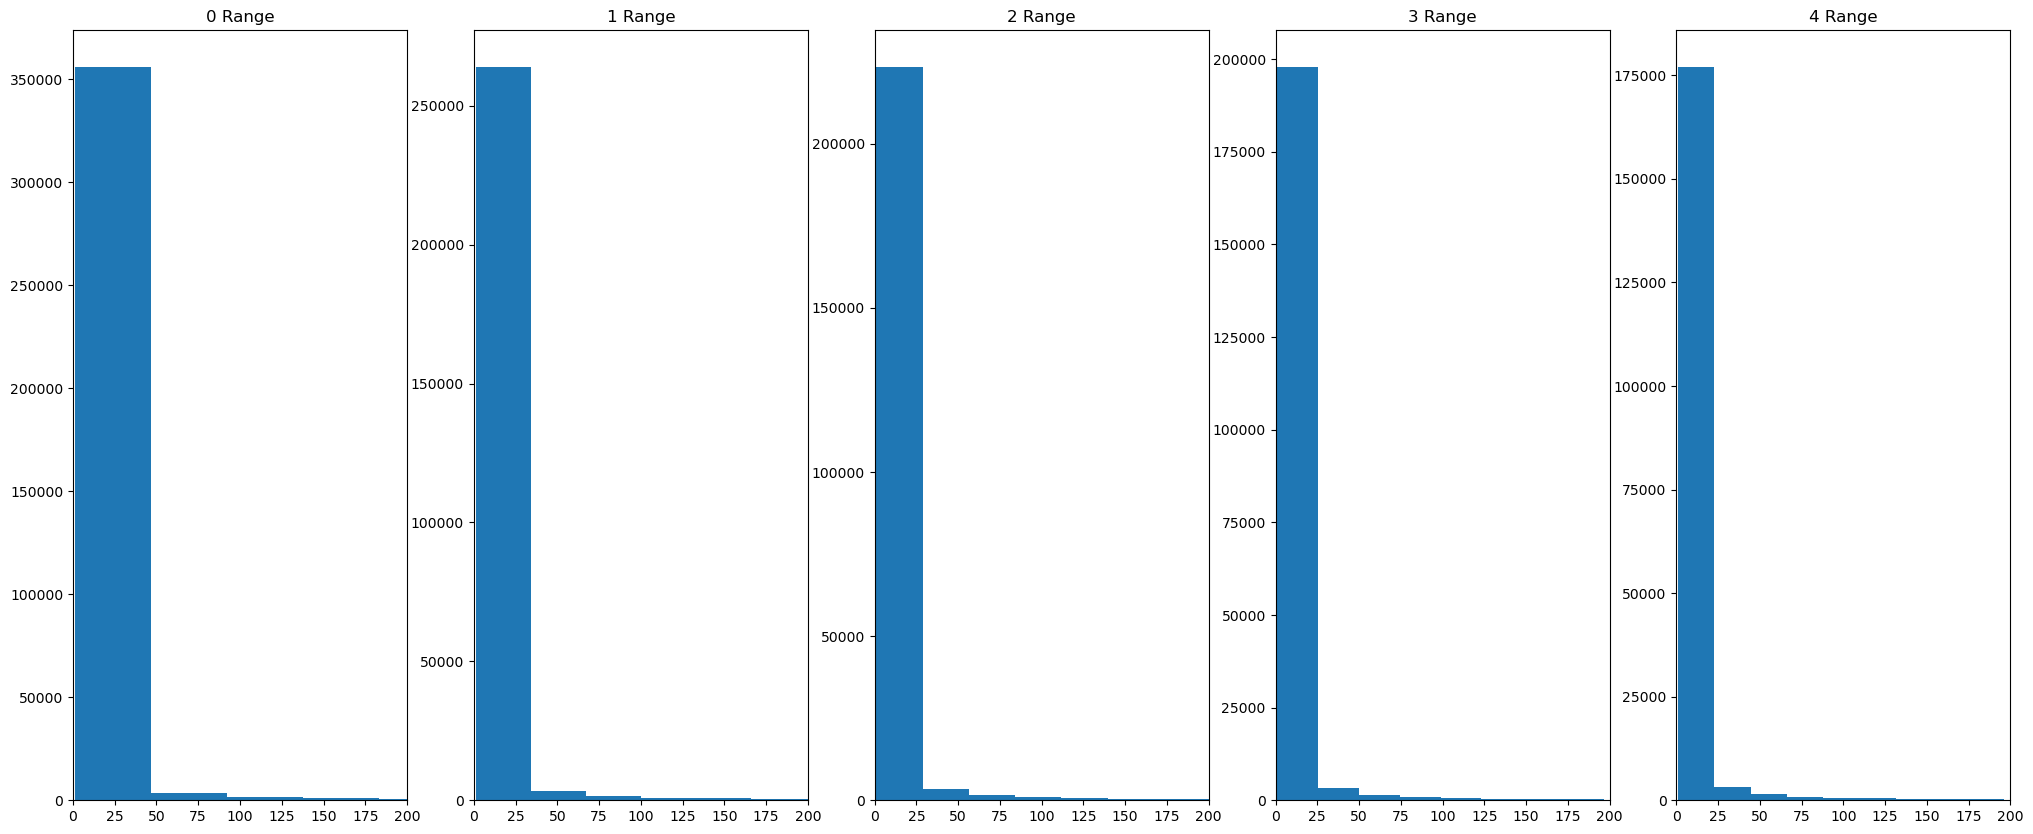

In [77]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(25, 10))
axes = axes.flatten()
for i in range(n):
    frequencies = np.array(list(counters_by_range[i].values()))
    axes[i].hist(frequencies, bins=1000)
    axes[i].set_xlim(0, 200)
    axes[i].set_title(f"{i} Range")

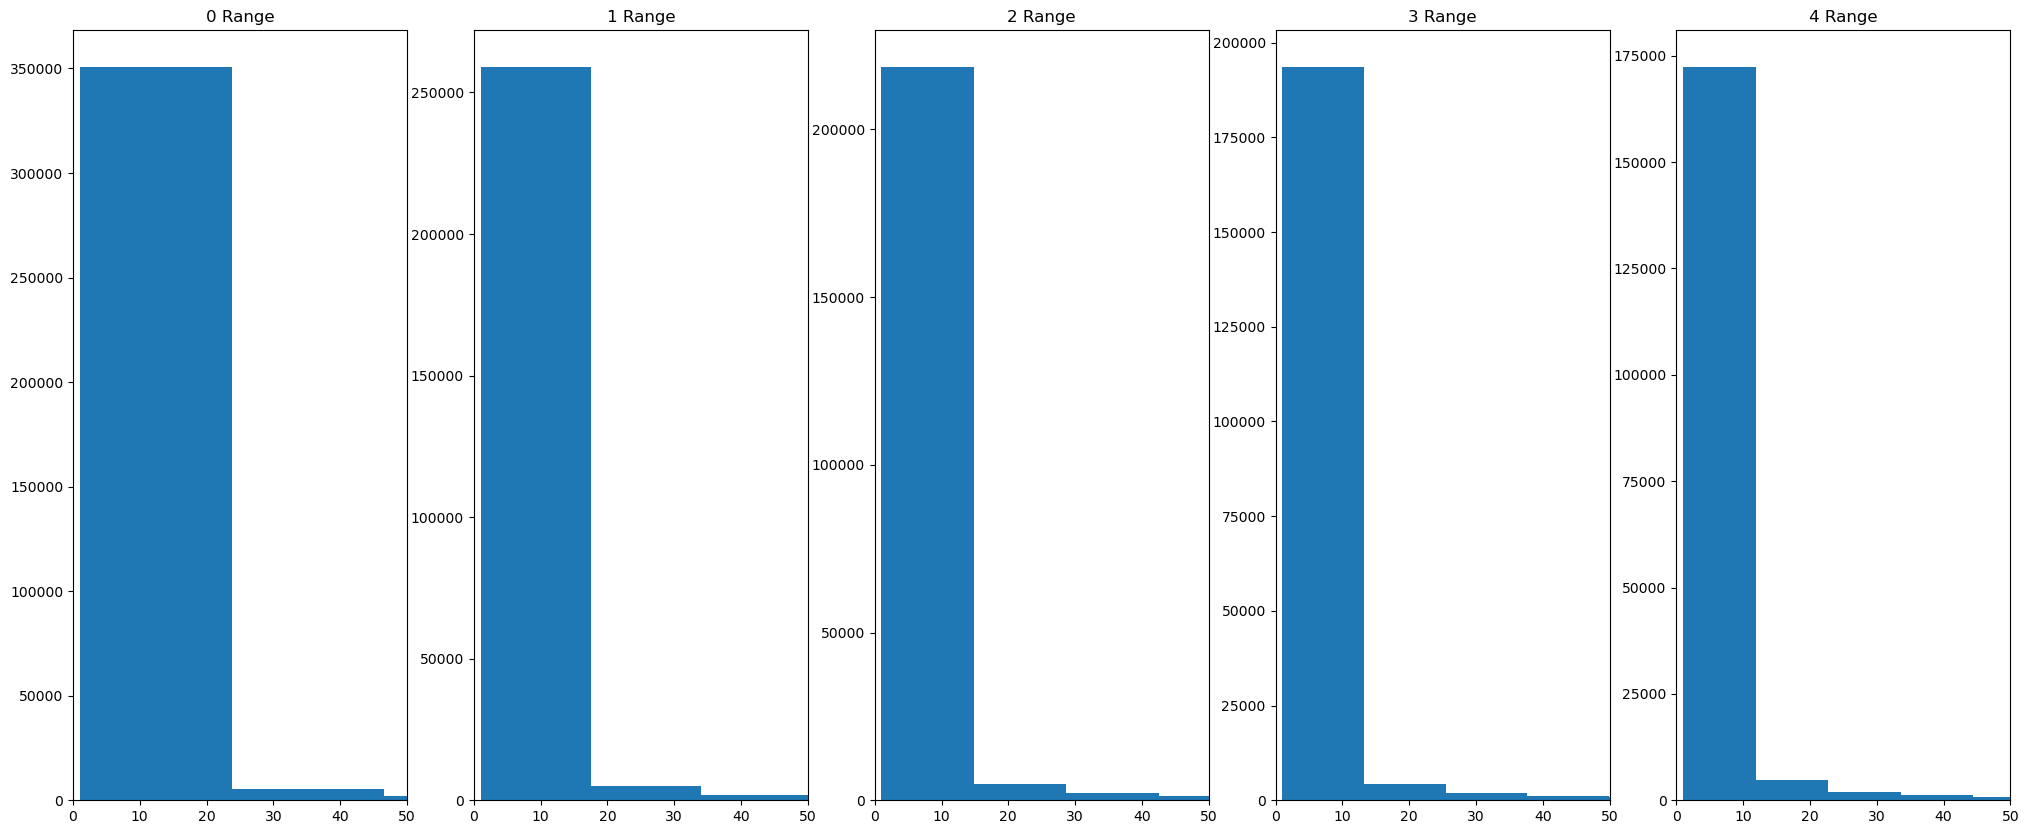

In [79]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(25, 10))
axes = axes.flatten()
for i in range(n):
    frequencies = np.array(list(counters_by_range[i].values()))
    axes[i].hist(frequencies, bins=2000)
    axes[i].set_xlim(0, 50)
    axes[i].set_title(f"{i} Range")

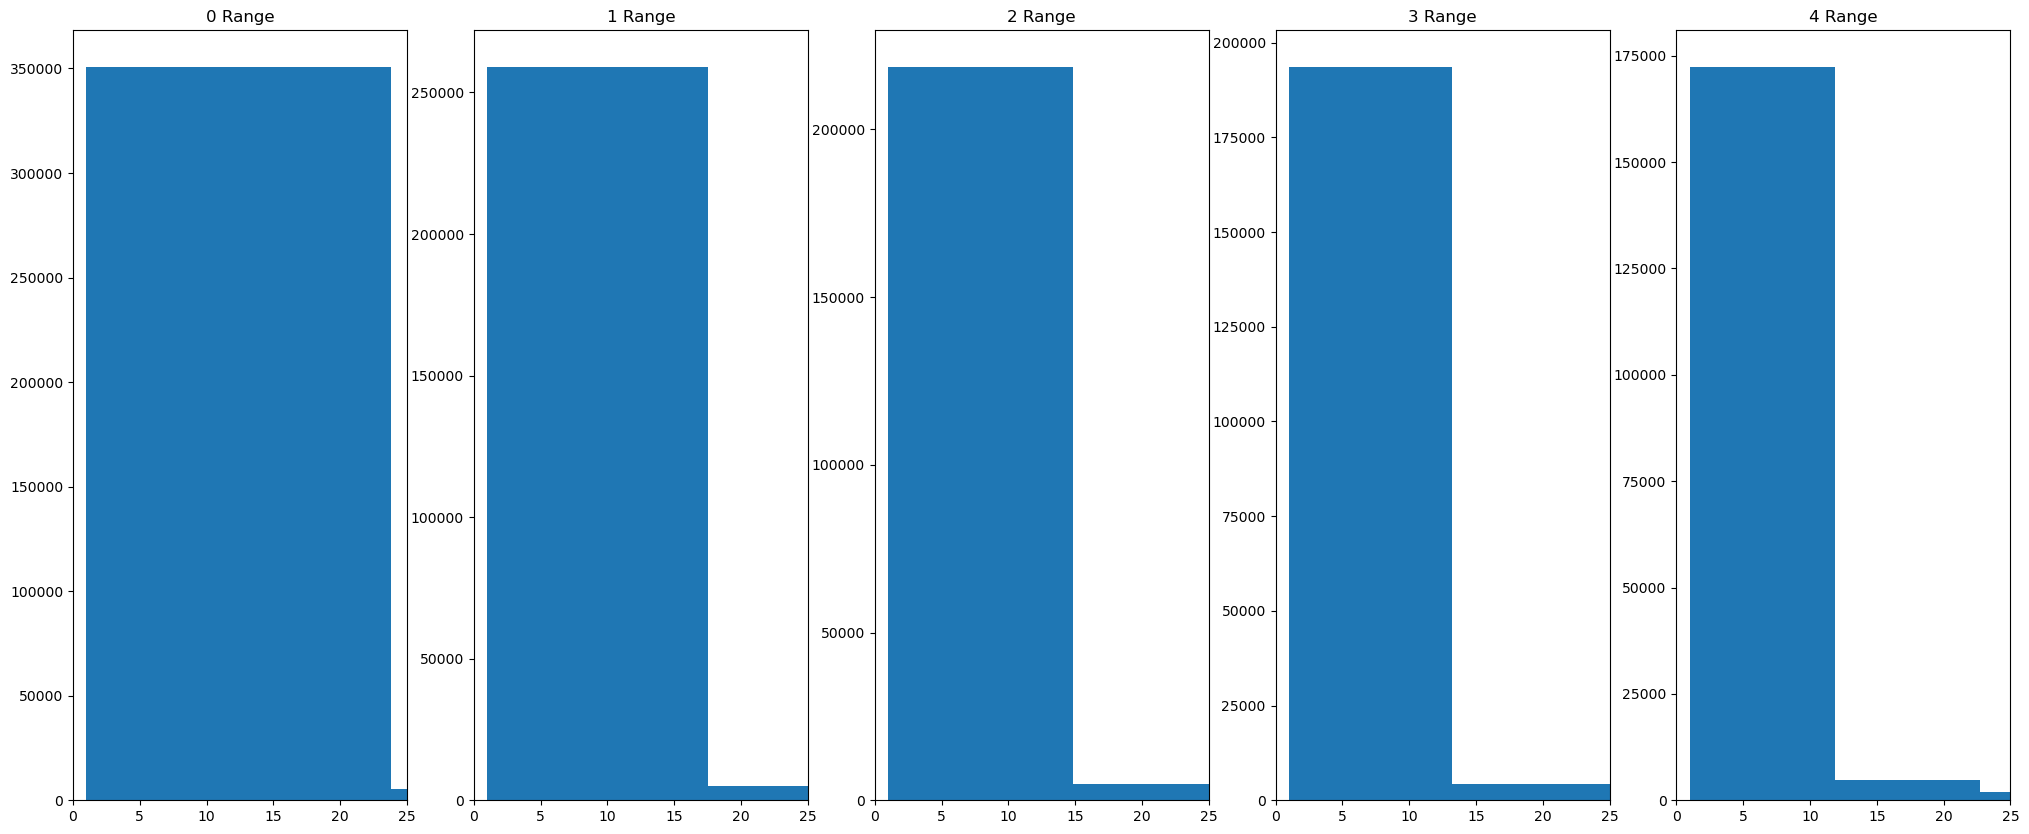

In [81]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(25, 10))
axes = axes.flatten()
for i in range(n):
    frequencies = np.array(list(counters_by_range[i].values()))
    axes[i].hist(frequencies, bins=2000)
    axes[i].set_xlim(0, 25)
    axes[i].set_title(f"{i} Range")

In [90]:
print('Самые редкие слова в постах')
print(list(map(lambda x: x[0], posts_counter.most_common()[::-1][:100])))

print('-'*100)
print('Самые редкие слова в комментариях')
words, frequency = [], []
print(list(map(lambda x: x[0], comments_counter.most_common()[::-1][:100])))

Самые редкие слова в постах
['chervonenkis', 'alexey', 'cve20146271', 'beyondpad', 'bent', 'nga', 'pockets', 'isro', '15pb', 'qtile', 'newsletterlist', 'experimented', 'oneboxio', 'cve20146273', 'splitscreen', 'waffle', 'dedesign', 'emailbased', 'standupmail', 'reactcursor', 'docks', 'deforestation', 'felixdicit', 'talko', 'shirtcodes', 'centennial', 'infinidb', 'slain', 'templeos', 'photoediting', 'mondrian', 'cve20144377', '71x', 'beehive', 'metacompressor', 'blosc', 'electrolysis', 'cellnetwork', 'athens', 'spinin', 'pathfindingjs', 'prerequisites', 'microservice', 'pinching', 'clamps', 'carmaking', 'moog', 'nonimportant', 'yttr', 'ungineering', 'uselessd', 'hipaacompliant', 'raidproof', 'conduit', 'shellconduit', 'ello', '117000', 'imprinting', '8byte', 'larch', 'readback', 'battleboatjs', 'rujit', 'gainsight', 'totango', 'glum', 'berners', 'bashbooster', 'lifetimes', 'draining', 'sshrc', 'smarteyeglass', 'notboring', 'rituals', 'allfemale', 'mdp', 'possess', 'exmode', '213', 'teet

In [ ]:
n = len(counters_by_range)
fig, axes = plt.subplots(3, 2, figsize=(20, 40))
axes = axes.flatten()
plt.suptitle('Самые частые слова')
for i in range(n):
    words, frequency = [], []
    for word, count in counters_by_range[i].most_common()[::-1][:30]:
        words.append(word[:20])
        frequency.append(count)
    sns.barplot(x=frequency, y=words, ax=axes[i])
    axes[i].set_title(f"{i} Range")

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
def count_ngrams(series, n=2):
    vec = CountVectorizer(stop_words=stop, ngram_range=(n,n), max_features=50)
    bow = vec.fit_transform(series)
    # Count frequency of ngrams
    count_values = bow.toarray().sum(axis=0)

    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame([(count_values[i], k) for k, i in vec.vocabulary_.items()])
    ngram_freq.columns = ["frequency", "ngram"]
    ngram_freq.sort_values(by = "frequency",  ascending = False, inplace = True)
    return ngram_freq

In [25]:
bigrams_posts = count_ngrams(posts_cleaned)

In [26]:
bigrams_comments = count_ngrams(comments_cleaned['text'])

Text(0.5, 1.0, 'Биграммы для комментариев(всех)')

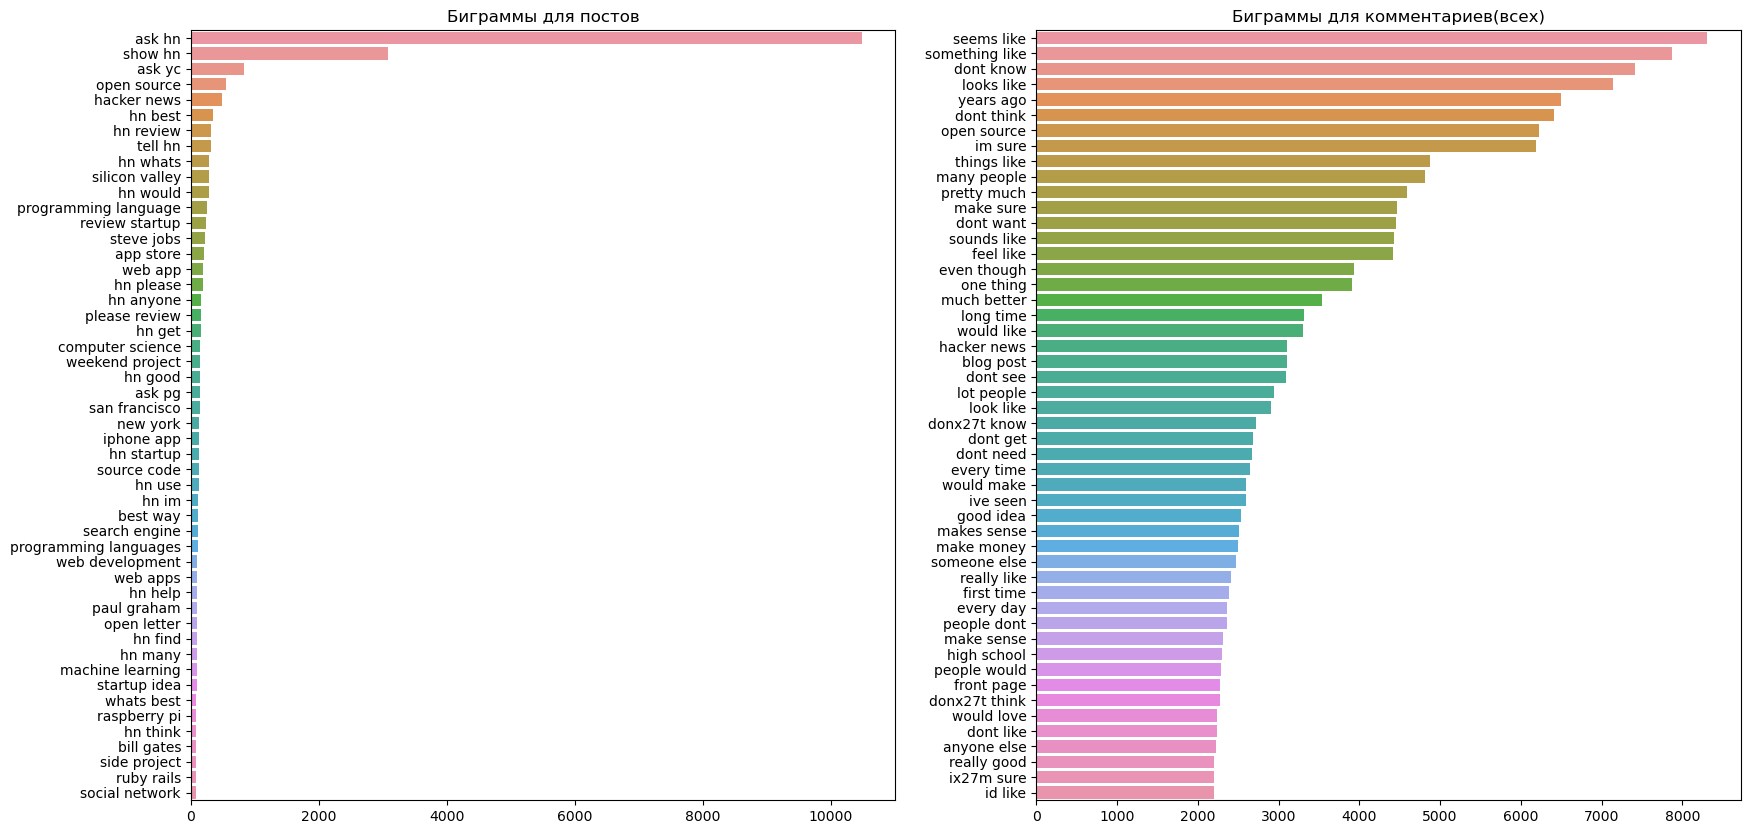

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

posts_freq, posts_words = bigrams_posts.values.T

sns.barplot(x=posts_freq, y=posts_words, ax=axes[0])
axes[0].set_title('Биграммы для постов')

posts_freq, posts_words = bigrams_comments.values.T

sns.barplot(x=posts_freq, y=posts_words, ax=axes[1])
axes[1].set_title('Биграммы для комментариев(всех)')

In [28]:
from tqdm import tqdm

bi_grams_by_range = []

for i in tqdm(range(5)):
    current_series = comments_cleaned[comments_cleaned['target'] == i]['text']
   
    bi_grams_by_range.append(count_ngrams(current_series))


100%|██████████| 5/5 [02:19<00:00, 27.84s/it]


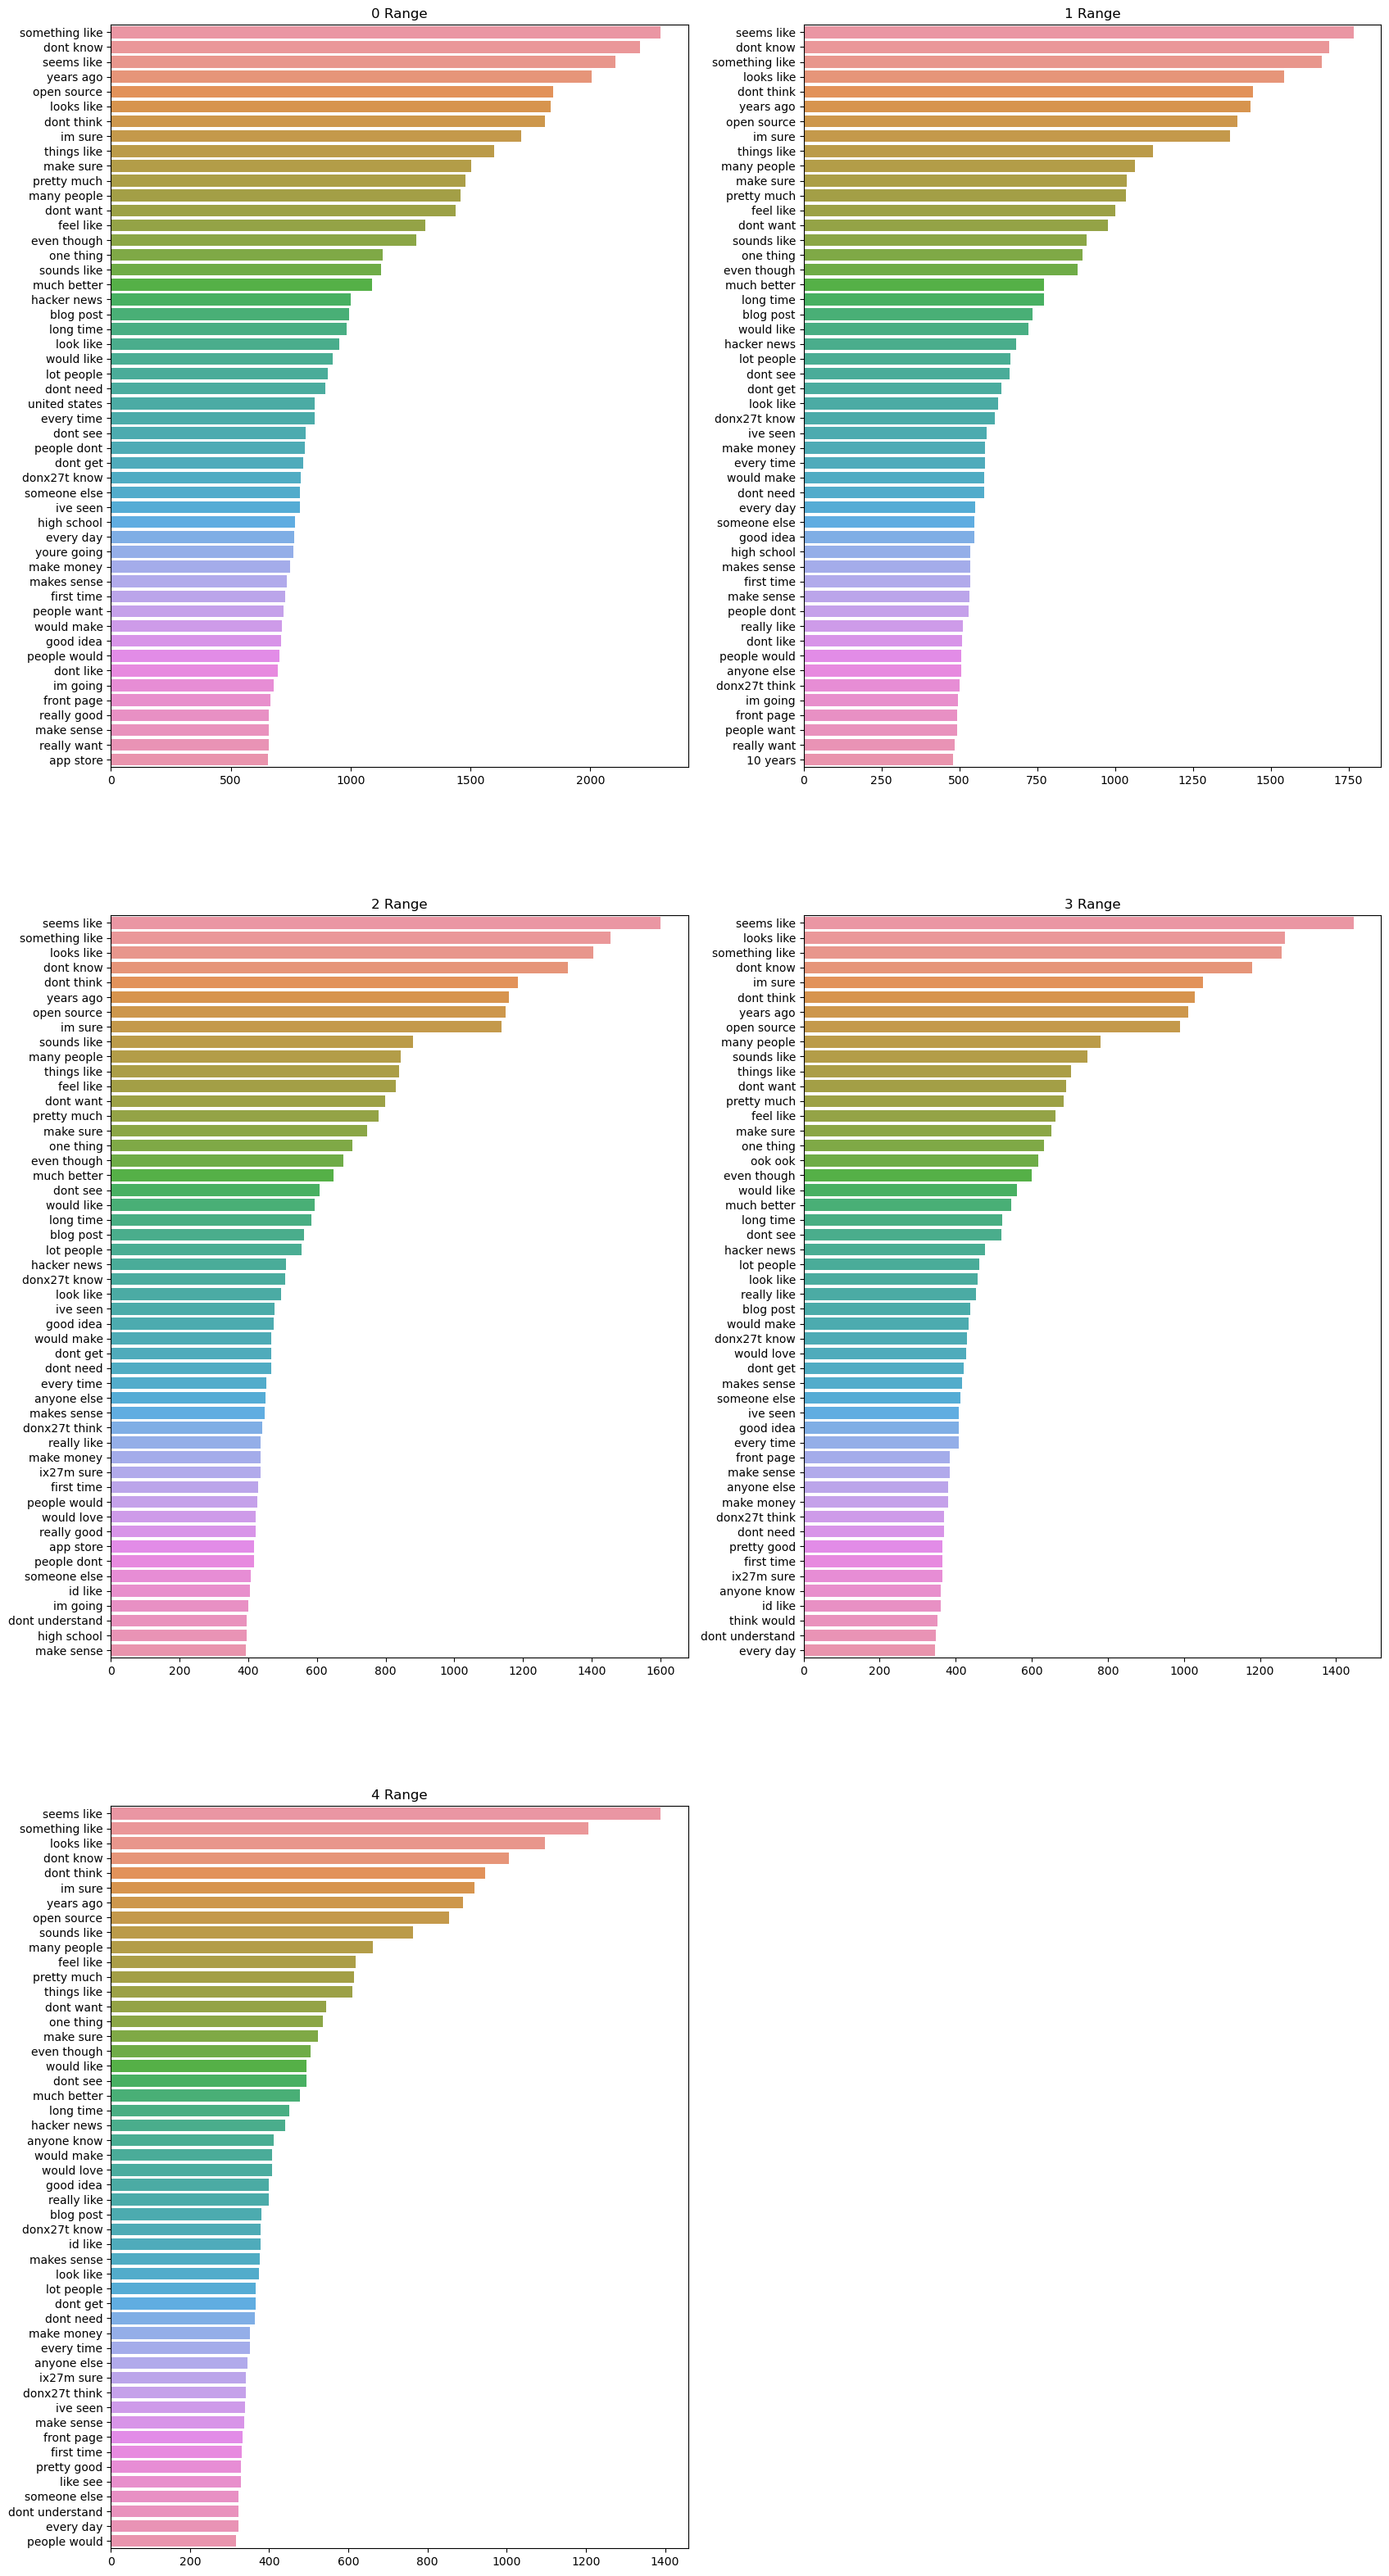

In [30]:
n = len(counters_by_range)
fig, axes = plt.subplots(3, 2, figsize=(20, 40))
axes = axes.flatten()
for i in range(n):
    posts_freq, posts_words = bi_grams_by_range[i].values.T
    sns.barplot(x=posts_freq, y=posts_words, ax=axes[i])
    axes[i].set_title(f"{i} Range")
axes[-1].remove()    

In [99]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

In [108]:
posts_corpus = ' '.join(posts_cleaned.values)

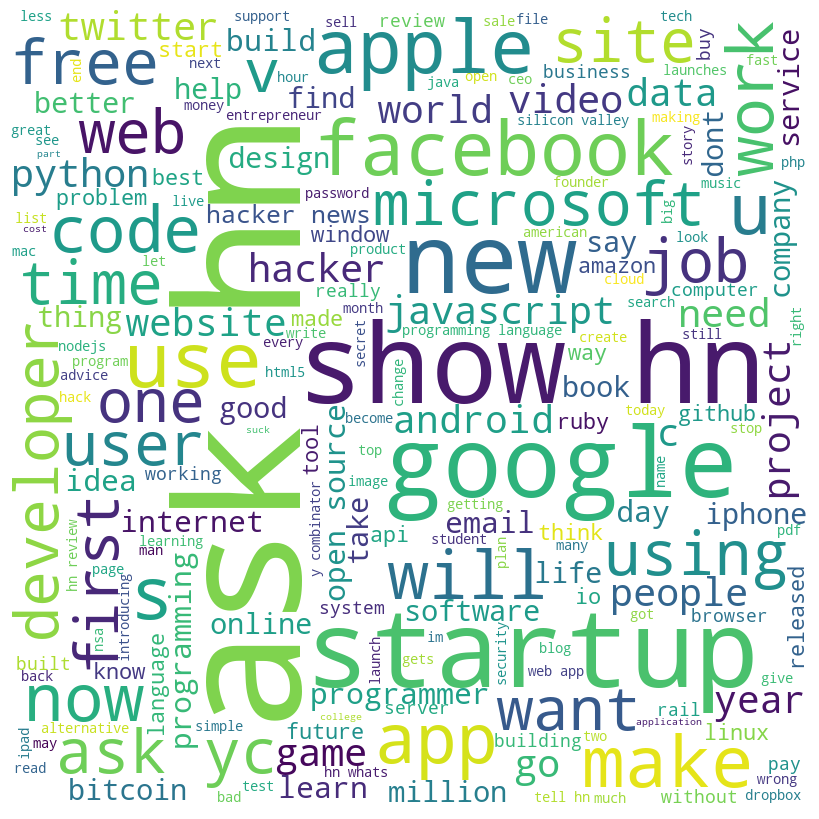

In [109]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(posts_corpus)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [104]:
comments_corpus = ' '.join(comments_cleaned['text'].values)

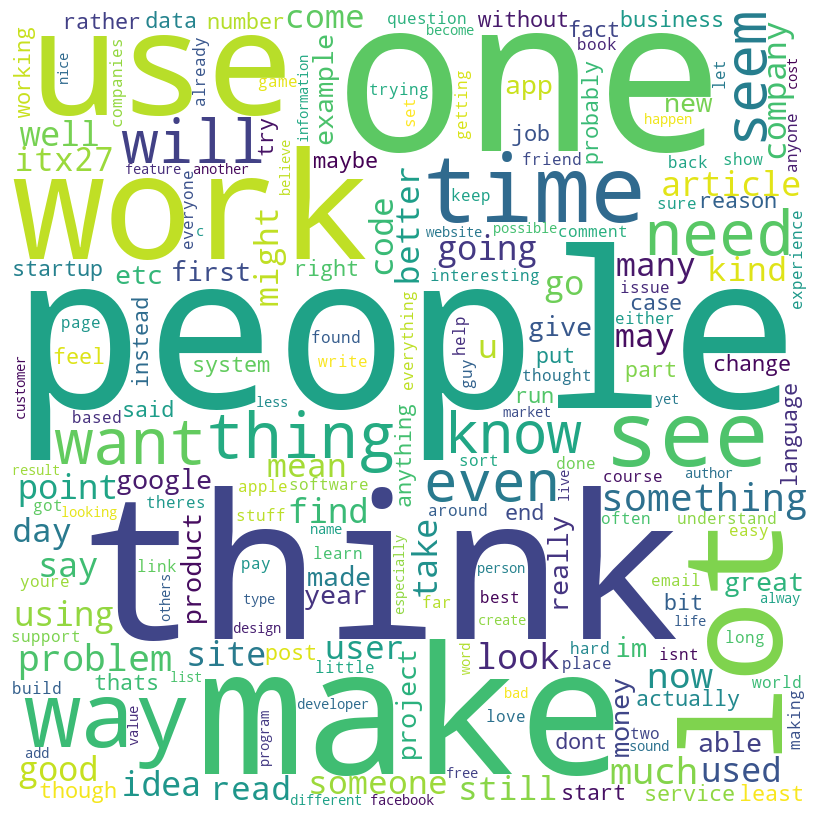

In [106]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comments_corpus)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

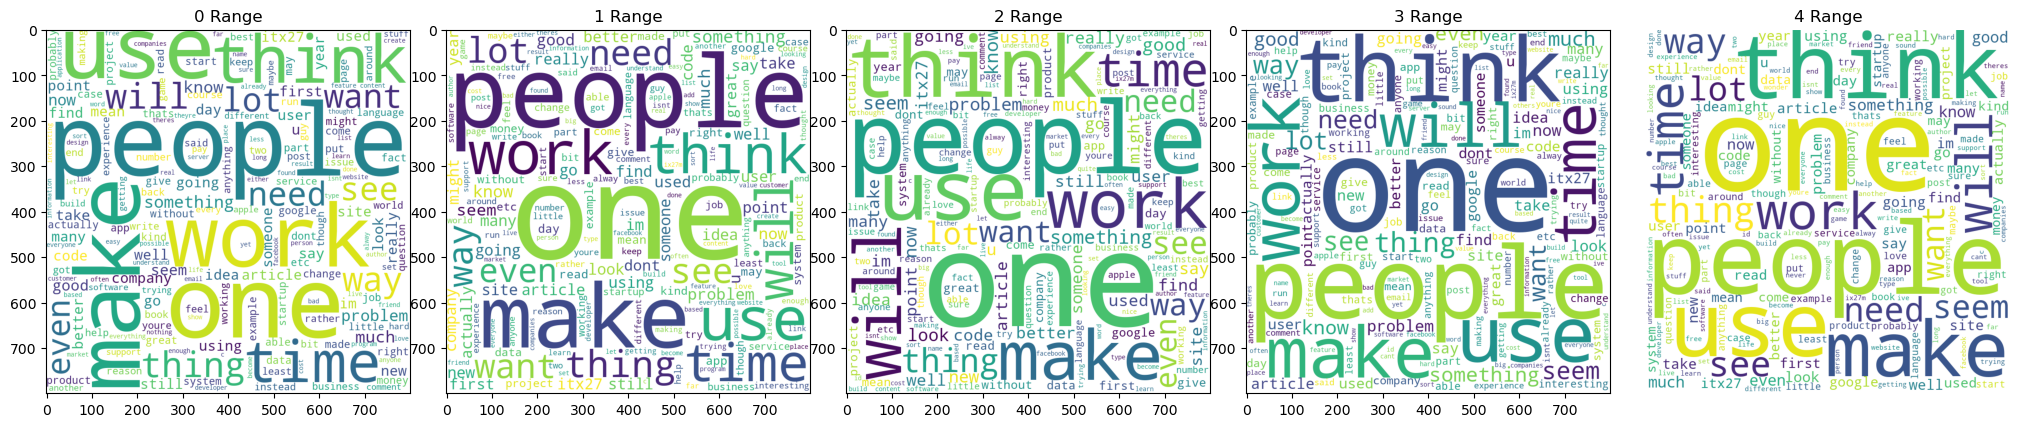

In [111]:
n = len(counters_by_range)
fig, axes = plt.subplots(1, n, figsize=(20, 5))
for i in range(n):
    corpus = ' '.join(comments_cleaned[comments_cleaned['target'] == i]['text'].values)
    
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(corpus)
 
    axes[i].imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    axes[i].set_title(f"{i} Range")

In [120]:
comments_lengths = comments_cleaned['text'].str.split().str.len()

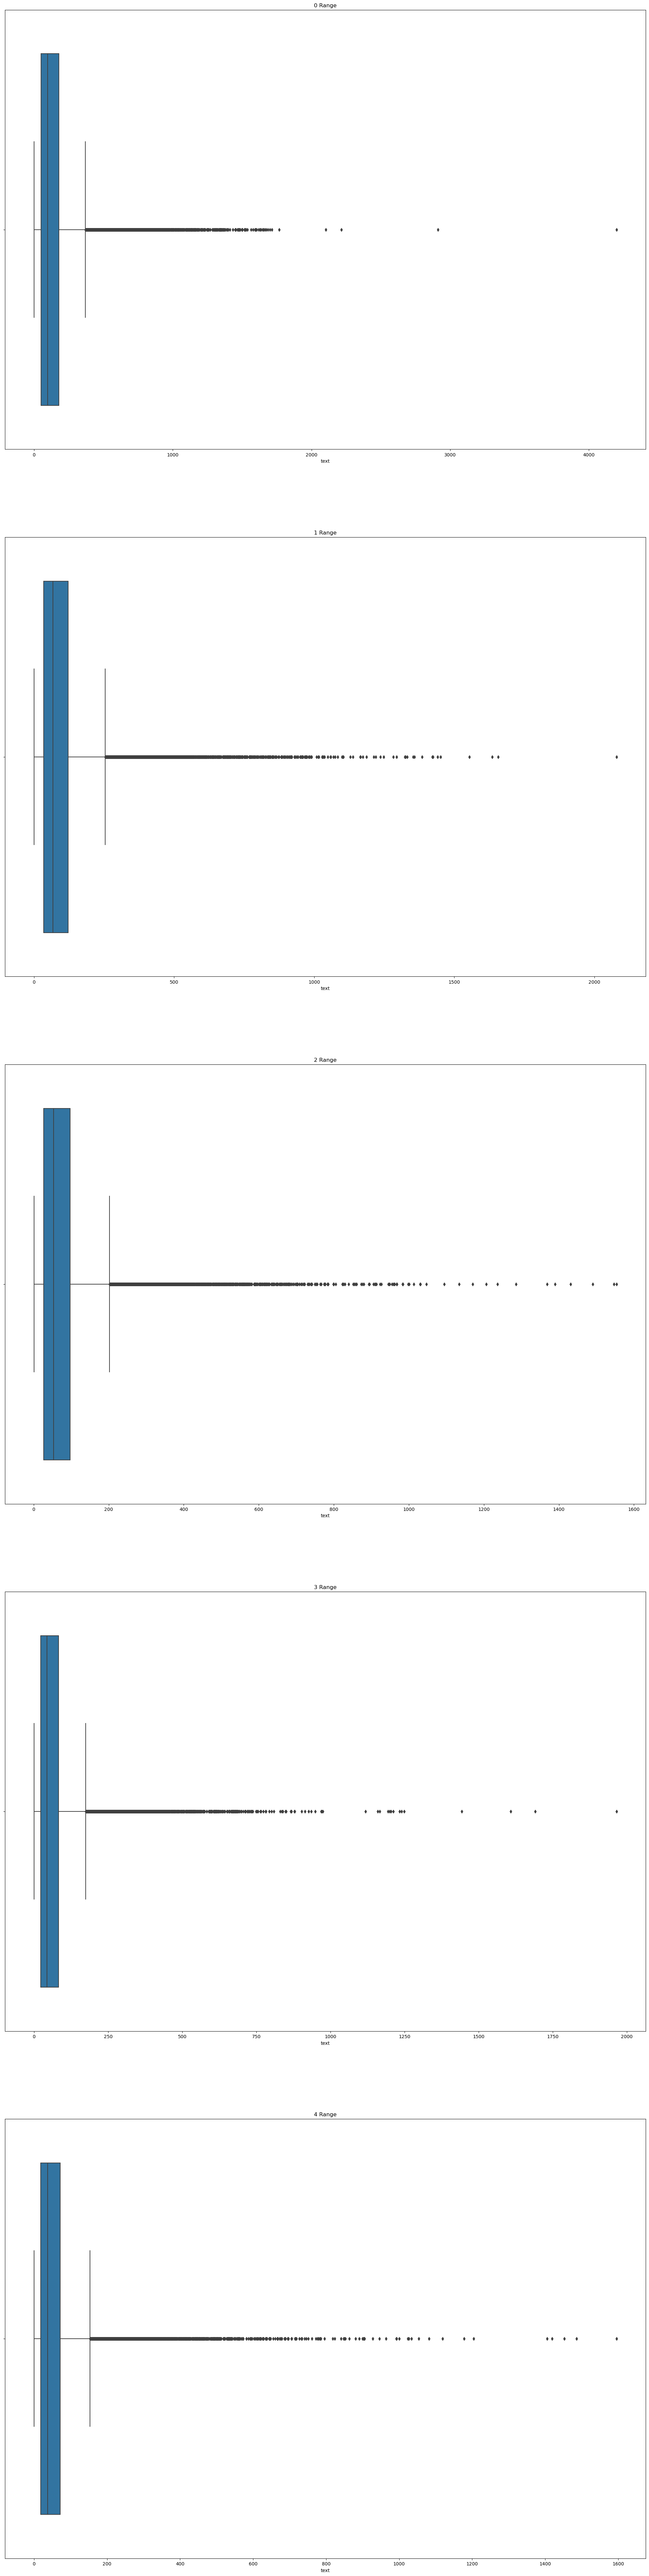

In [127]:
n = len(counters_by_range)
fig, axes = plt.subplots(n, 1, figsize=(25, 100))
axes = axes.flatten()
for i in range(n):
    comments_current = comments_lengths[comments_cleaned['target'] == i]
 
    sns.boxplot(x=comments_current, ax=axes[i])

    axes[i].set_title(f"{i} Range")